# --- CELL 1: 库导入与环境设置 ---

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import zipfile

# 检查 GPU
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# 定义关键参数 (Top 30% 的关键设置)
IMAGE_SIZE = (224, 224)  # ResNet 喜欢这个尺寸
BATCH_SIZE = 32
EPOCHS_HEAD = 5          # 第一阶段轮数
EPOCHS_FINE = 10         # 第二阶段微调轮数

2025-12-03 08:48:04.282617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764751684.514458      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764751684.579279      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# --- CELL 2: 解压数据  ---

In [2]:
print("📦 正在解压数据，请稍候...")

with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip","r") as z:
    z.extractall(".")

print("✅ 解压完成！")

📦 正在解压数据，请稍候...
✅ 解压完成！


# --- CELL 3: 整理数据列表 ---

In [3]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1) # 1 = Dog
    else:
        categories.append(0) # 0 = Cat

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
#把类别转成字符串，因为 flow_from_dataframe 需要字符串
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'}) 

print(df.head())
print(f"总图片数: {df.shape[0]}")

        filename category
0  cat.10923.jpg      cat
1    cat.119.jpg      cat
2   dog.4598.jpg      dog
3   dog.2275.jpg      dog
4   dog.3993.jpg      dog
总图片数: 25000


# --- CELL 4: 数据增强生成器  ---

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,        # 归一化
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1   # 划分 10% 做验证
)

# 验证集不需要增强，只需要归一化
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# 构建训练集流
train_generator = train_datagen.flow_from_dataframe(
    df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

# 构建验证集流
validation_generator = validation_datagen.flow_from_dataframe(
    df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


# --- CELL 5: 构建 ResNet50V2 模型 ---

In [5]:
print("🔹 构建模型中...")

# 1. 加载预训练的 ResNet50V2 
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. 冻结基础模型 (第一阶段不训练骨干)
base_model.trainable = False

# 3. 添加自定义分类头
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # 防止过拟合
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. 编译模型
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

🔹 构建模型中...


I0000 00:00:1764751712.938686      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764751712.939411      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# --- CELL 6: 第一阶段训练  ---

In [6]:
print("🚀 阶段一：训练分类头 (Warm-up)...")
history_1 = model.fit(
    train_generator,
    epochs=EPOCHS_HEAD,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    steps_per_epoch=len(train_generator)
)

🚀 阶段一：训练分类头 (Warm-up)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1764751722.806186     111 service.cc:148] XLA service 0x7aa9040106d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764751722.807188     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764751722.807211     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764751724.119405     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/704 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.6875 - loss: 0.8744   

I0000 00:00:1764751730.736281     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 264s 355ms/step - accuracy: 0.9637 - loss: 0.1218 - val_accuracy: 0.9836 - val_loss: 0.0426
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 245s 348ms/step - accuracy: 0.9816 - loss: 0.0519 - val_accuracy: 0.9852 - val_loss: 0.0413
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - accuracy: 0.9826 - loss: 0.0482 - val_accuracy: 0.9868 - val_loss: 0.0360
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 240s 341ms/step - accuracy: 0.9828 - loss: 0.0440 - val_accuracy: 0.9864 - val_loss: 0.0336
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 239s 340ms/step - accuracy: 0.9818 - loss: 0.0464 - val_accuracy: 0.9860 - val_loss: 0.0389


# --- CELL 7: 第二阶段训练 (微调) ---

In [7]:
print("阶段二：解冻顶层并微调 (Fine-tuning)...")

# 1. 设置解冻策略
base_model.trainable = True

#先冻结所有层，然后只解冻最后 30 层
for layer in base_model.layers[:-30]: 
    layer.trainable = False

# 2. 重新编译 (微调必须用很小的学习率)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 3. 设置早停 
callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')
]

# 4. 训练 
history_2 = model.fit(
    train_generator,
    epochs=5, 
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    steps_per_epoch=len(train_generator),
    callbacks=callbacks
)

阶段二：解冻顶层并微调 (Fine-tuning)...
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 269s 359ms/step - accuracy: 0.9681 - loss: 0.0897 - val_accuracy: 0.9864 - val_loss: 0.0381
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - accuracy: 0.9819 - loss: 0.0465 - val_accuracy: 0.9884 - val_loss: 0.0339
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - accuracy: 0.9868 - loss: 0.0393 - val_accuracy: 0.9880 - val_loss: 0.0359
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 243s 344ms/step - accuracy: 0.9894 - loss: 0.0290 - val_accuracy: 0.9888 - val_loss: 0.0383
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 245s 348ms/step - accuracy: 0.9918 - loss: 0.0230 - val_accuracy: 0.9884 - val_loss: 0.0369


# --- CELL 8: 可视化训练曲线 ---

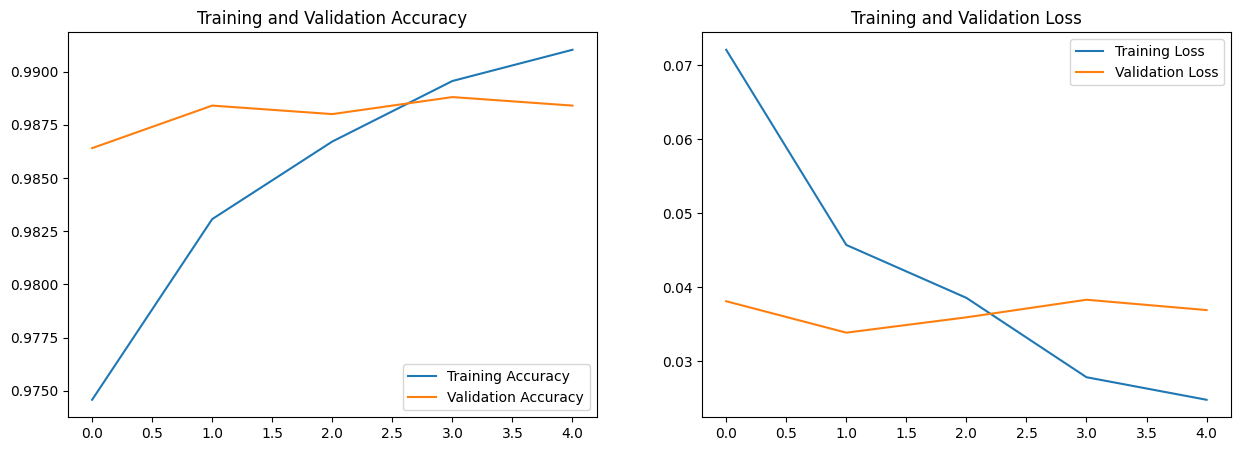

In [8]:
import matplotlib.pyplot as plt

# 主要看第二阶段（微调）的曲线，这才是模型真正变强的地方
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# --- CELL 9: 补充可视化混淆矩阵 ---

正在对验证集进行评估...
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step


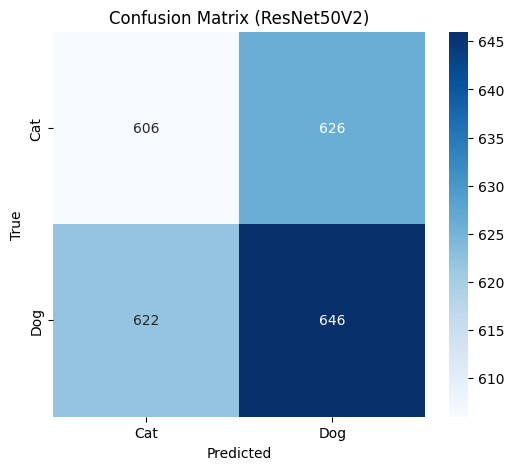

              precision    recall  f1-score   support

         Cat       0.49      0.49      0.49      1232
         Dog       0.51      0.51      0.51      1268

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.50      0.50      0.50      2500



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. 让验证集生成器重置，并预测一遍
validation_generator.reset()
# 预测
print("正在对验证集进行评估...")
val_preds = model.predict(validation_generator, verbose=1)
val_pred_classes = np.argmax(val_preds, axis=1)

# 2. 获取真实标签
val_true_classes = validation_generator.classes

# 3. 画图
cm = confusion_matrix(val_true_classes, val_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ResNet50V2)')
plt.show()

# 打印报告
print(classification_report(val_true_classes, val_pred_classes, target_names=['Cat', 'Dog']))

# --- CELL 10: 可视化Grad-CAM 热力图 ---

正在生成热力图...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipykernel_47/3923277496.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl_cm.get_cmap("jet")


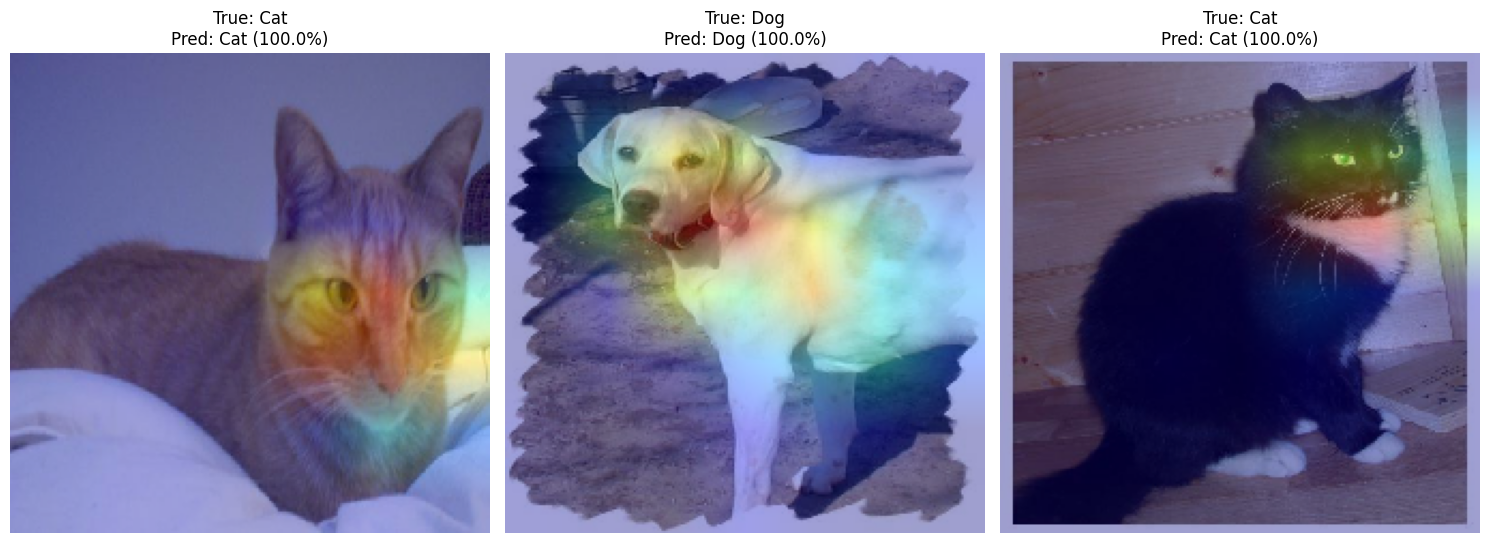

In [10]:
import matplotlib.cm as mpl_cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 构建专门用于Grad-CAM的子模型
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.6):
    jet = mpl_cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet_heatmap = jet_colors[heatmap_uint8]
    
    # 调整大小
    jet_heatmap = tf.image.resize(jet_heatmap, (img.shape[0], img.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # 叠加
    # 注意：这里的img已经是0-1归一化的，所以要乘255
    superimposed_img = jet_heatmap * 255 * alpha + img * 255
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

# --- 执行可视化 ---
# 获取 ResNet50V2 的最后一个卷积层名字
last_conv_layer_name = "post_relu" 

print("正在生成热力图...")
validation_generator.reset()
# 取出一批图片
x_batch, y_batch = next(validation_generator)

plt.figure(figsize=(15, 6))
num_images = 3

for i in range(num_images):
    img = x_batch[i] # 这是一个 (224, 224, 3) 的图
    img_array = np.expand_dims(img, axis=0) # 增加 batch 维度
    
    # 预测
    preds = model.predict(img_array, verbose=0)
    pred_label = "Dog" if np.argmax(preds)==1 else "Cat"
    true_label = "Dog" if np.argmax(y_batch[i])==1 else "Cat"
    conf = np.max(preds)
    
    # 生成热力图
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        result_img = display_gradcam(img, heatmap)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(result_img)
        plt.title(f"True: {true_label}\nPred: {pred_label} ({conf:.1%})")
        plt.axis('off')
    except Exception as e:
        print(f"热力图生成失败: {e}")
        # 如果 post_relu 找不到，尝试 conv5_block3_out
        print("请尝试将 last_conv_layer_name 改为 'conv5_block3_out'")

plt.tight_layout()
plt.show()

# --- CELL 11: 准备测试集并预测 ---

In [14]:
print(" 正在预测测试集...")

# 准备测试集文件名
test_filenames = os.listdir("./test")
test_df = pd.DataFrame({'filename': test_filenames})
nb_samples = test_df.shape[0]

# 测试集生成器 
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
   "./test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 预测
predict = model.predict(test_generator, steps=int(np.ceil(nb_samples/BATCH_SIZE)))

 正在预测测试集...
Found 12500 validated image filenames.
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step


# --- CELL 12: 生成提交文件 ---

In [17]:
# 1. 提取预测结果

test_df['label'] = predict[:, 1] 

# 2. 提取数字 ID
test_df['id'] = test_df['filename'].str.split('.').str[0]

# 3. 整理最终格式 
submission_df = test_df[['id', 'label']].copy()

# 4. 按 ID 排序 
submission_df.sort_values(by=['id'], key=lambda x: x.astype(int), inplace=True)

# 5. 保存 CSV
submission_df.to_csv('submission.csv', index=False)

print(" submission.csv已生成！")
print(submission_df.head())

 submission.csv已生成！
     id     label
7872  1  1.000000
7149  2  0.999997
5350  3  0.999999
1856  4  0.999967
8212  5  0.000035
